In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from scipy.stats import pearsonr

from easydict import EasyDict as edict
from collections import defaultdict as ddict
from tqdm import trange, tqdm
from scipy.io import loadmat

plt.style.use('ggplot')
plt.rcParams["savefig.bbox"] = "tight"

In [3]:
from utils.misc import save_pkl, load_pkl
from constants import RES_ROOT, DATA_ROOT, FIG_ROOT
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse
from hdf_utils.SIS import SIS_linear
from splines import obt_bsp_basis_Rfn

## Parameters and fns

### Params

In [4]:
_paras = edict()
_paras.res_dir = RES_ROOT/"linear_SIS_100_Nmanual_penalize_all"

### Fn

In [5]:
def _beta_err_bd(paras):
    diff = paras.beta_GT -  paras.basis_mat.numpy() @ paras.Gam_est
    beta_GT_fnl2 = np.linalg.norm(np.sqrt((np.mean(paras.beta_GT**2, axis=0))))
    err_bd = np.linalg.norm(np.sqrt(np.mean(diff**2, axis=0)))/beta_GT_fnl2
    return err_bd

In [6]:
def _filename2paras(p):
    """Get the parameters (lam, Rfct, n) based on filename
    """
    sep_p = p.stem.split("_")
    res = edict()
    assert sep_p[1].startswith("lam")
    assert sep_p[2].startswith("N")
    assert sep_p[3].startswith("n")
    lam_v = int(sep_p[1].split("-")[-1])/100
    N_v = int(sep_p[2].split("-")[-1])
    n_v = int(sep_p[3].split("-")[-1])
    
    res.N = N_v
    res.n = n_v
    res.lam = lam_v
    return res

In [7]:
def _res2err(opt, paras):
    """The fn to return the error,
        error  = ||est-gt||/||gt||
    """
    
    _paras = edict(paras.copy())
    errs = edict()
    alp_est = opt.thetak[:_paras.q].numpy()
    gam_est = opt.Gamk.numpy()
    beta_est_from_opt = _paras.basis_mat.numpy() @ opt.Gamk.numpy()
    beta_est = np.zeros_like(_paras.beta_GT)
    beta_est[:, _paras.keep_idxs] = beta_est_from_opt
    
    beta_diff = np.asarray(beta_est - _paras.beta_GT)
    alp_diff = alp_est - _paras.alp_GT
        
    beta_est_l0 = np.linalg.norm(beta_est, axis=0)[_paras.sel_idx] == 0
    beta_gt_l0 = np.linalg.norm(_paras.beta_GT, axis=0)[_paras.sel_idx] == 0
    errs.beta_err_l0 = np.bitwise_xor(beta_est_l0, beta_gt_l0).sum()
    errs.beta_err_l0_neg = (beta_gt_l0.astype(int) -  beta_est_l0.astype(int))[np.bitwise_not(beta_gt_l0)].sum()
        
    errs.beta_err_l1 = np.abs(beta_diff).sum()
    errs.beta_err_l2 = np.linalg.norm(beta_diff)
        
    errs.alp_err_l1 = np.abs(alp_diff).sum()/(np.abs(_paras.alp_GT).sum())
    errs.alp_err_l2 = np.linalg.norm(alp_diff)/np.linalg.norm(_paras.alp_GT)
        
    beta_GT_fnl1 = np.mean(np.abs(_paras.beta_GT), axis=0).sum()
    beta_GT_fnl2 = np.linalg.norm(np.sqrt((np.mean(_paras.beta_GT**2, axis=0))))
        
    beta_loss_fnl1 = np.mean(np.abs(beta_diff), axis=0)
    beta_loss_fnl2 = np.sqrt(np.mean(beta_diff**2, axis=0))
    errs.beta_err_l1 = beta_loss_fnl1.sum()/beta_GT_fnl1
    errs.beta_err_l2 = np.linalg.norm(beta_loss_fnl2)/beta_GT_fnl2
    return errs

## Load data

## Analysis-sampe-wise

In [74]:
cur_n = 24300
fils = list(_paras.res_dir.glob(f"result_*n-{cur_n}*.pkl"))
sorted_fils = sorted(fils, key=lambda x: _filename2paras(x).lam*10000+_filename2paras(x).N*1)

In [75]:
# load file first to save time
resss = []
for cur_fil in tqdm(sorted_fils):
    ress = load_pkl(cur_fil)
    resss.append(ress)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.14s/it]


In [76]:
tmp_paras = resss[0][0][-1]
err_mats = ddict(lambda : np.zeros((tmp_paras.num_rep, len(tmp_paras.can_lams), len(tmp_paras.can_Ns)))+100)
cv_err_mat =  np.zeros((tmp_paras.num_rep, len(tmp_paras.can_lams), len(tmp_paras.can_Ns))) + 100
for ix, cur_fil in enumerate(sorted_fils):
    ress = resss[ix]
    cur_paras = ress[0][-1]
    
    cur_para = _filename2paras(cur_fil)
    row_idx = cur_paras.can_lams.index(cur_para.lam)
    col_idx = cur_paras.can_Ns.index(cur_para.N)
    
    
    errs = []
    cv_errs = []
    for cur_res in ress:
        err =_res2err(cur_res[0][0], cur_paras)
        errs.append(err)
        cv_errs.append(np.mean(cur_res[1]**2))
            
    cv_err_mat[:, row_idx, col_idx] = np.array(cv_errs)
    for key in err.keys():
        sel_err = np.array([cur_err[key] for cur_err in errs])
        err_mats[key][:, row_idx, col_idx] = sel_err
err_mats = edict(err_mats)
save_pkl(_paras.res_dir/f"err_mats_{cur_n}.pkl", err_mats, 1)
save_pkl(_paras.res_dir/f"cv_err_mat_{cur_n}.pkl", cv_err_mat, 1)

Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../results/linear_SIS_100_Nmanual_penalize_all/err_mats_24300.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../results/linear_SIS_100_Nmanual_penalize_all/cv_err_mat_24300.pkl


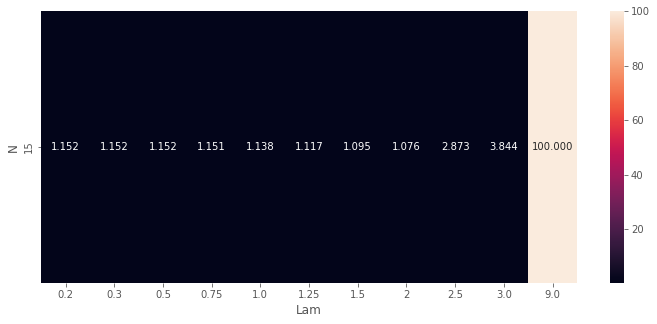

In [35]:
plt.figure(figsize=[12, 5])
cur_mat = np.median(err_mats.beta_err_l2, axis=0)
cv_mat = np.median(cv_err_mat, axis=0)
sns.heatmap(cur_mat.T, annot=np.round(cv_mat.T, 3), square=0, fmt=".3f")
plt.ylabel("N")
plt.xlabel("Lam")
plt.yticks(np.arange(len(tmp_paras.can_Ns))+0.5, tmp_paras.can_Ns)
plt.xticks(np.arange(len(tmp_paras.can_lams))+0.5, tmp_paras.can_lams);
#plt.savefig(FIG_ROOT/f"linear_1_overall_l2_{cur_n}.jpg")

## The beta curve

In [114]:
cur_n = 300
cur_lam = 2
cur_N = 5
cur_fil = list(_paras.res_dir.glob(f"result_*lam-{cur_lam*100:.0f}_N-*_n-{cur_n}*.pkl"))[0]
cur_ress = load_pkl(cur_fil)

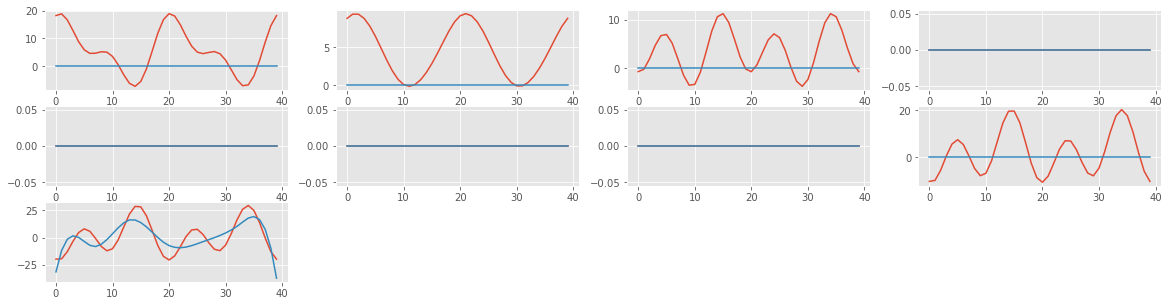

In [115]:
exp_idx = 1
opt = cur_ress[exp_idx][0][0]
cur_paras = cur_ress[exp_idx][2]
beta_est_from_opt = cur_paras.basis_mat.numpy() @ opt.Gamk.numpy()
beta_est = np.zeros_like(cur_paras.beta_GT)
beta_est[:, cur_paras.keep_idxs] = beta_est_from_opt
plt.figure(figsize=[20, 5])
for ix, roi_id in enumerate([0, 1, 2, 3, 4, 5, -3, -2, -1]):
    plt.subplot(3, 4, ix+1)
    plt.plot(cur_paras.beta_GT[:, roi_id])
    plt.plot(beta_est[:, roi_id])

## Analysis-all

In [8]:
for n in tmp_paras.ns:
    print(n, np.round(4.4*n**(1/tmp_paras.ord/2), 0))

NameError: name 'tmp_paras' is not defined

In [9]:
fils = list(_paras.res_dir.glob(f"err_mats_*.pkl"))
cv_fils = list(_paras.res_dir.glob(f"cv_err_mat_*.pkl"))
sorted_fils = sorted(fils, key=lambda x:int(x.stem.split("_")[-1]))
sorted_cv_fils = sorted(cv_fils, key=lambda x:int(x.stem.split("_")[-1]))

tmp_fils = list(_paras.res_dir.glob("result_lam-20_N-*.pkl"))
sorted_tmp_fils = sorted(tmp_fils, key=lambda x:int(x.stem.split("-")[-1]))

Text(0.5, 0, 'Sample size')

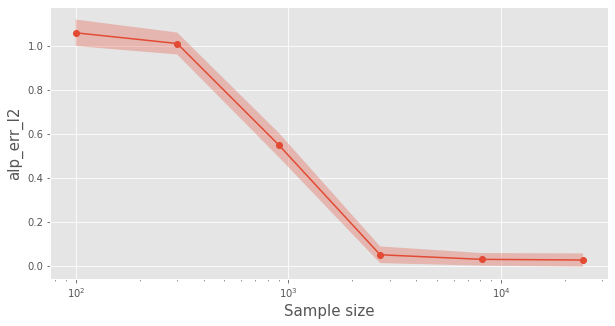

In [10]:
# errtypes are 
#['beta_err_l0', 'beta_err_l0_neg',
# 'beta_err_l1', 'beta_err_l2', 
#'alp_err_l1', 'alp_err_l2', 
err_type = "alp_err_l2"
ns = []
errs = []
err_ses = []
min_errs = []
best_lams = []
for ix, cur_fil in enumerate(sorted_fils):
    err_mats = load_pkl(cur_fil)
    cv_err_mat = load_pkl(sorted_cv_fils[ix])
    cur_paras = load_pkl(sorted_tmp_fils[ix])[0][2]
    
    ns.append(int(cur_fil.stem.split("_")[-1]))
    
    err_v = np.median(err_mats[err_type], axis=0)
    # adjust for sample median, 
    err_v_se = np.sqrt(np.pi/2)*np.std(err_mats[err_type], axis=0)/np.sqrt(err_mats[err_type].shape[0])
    cv_err_v = np.median(cv_err_mat, axis=0)
    #print(np.concatenate([cv_err_v, err_v], axis=1))
    min_v = np.min(cv_err_v[:, :])
    
    best_lams.append(cur_paras.can_lams[np.argwhere(cv_err_v.reshape(-1) == min_v)[0][0]])
    #errs.append(np.min(err_v))
    errs.append(err_v[cv_err_v==min_v])
    err_ses.append(err_v_se[cv_err_v==min_v])
    min_errs.append(_beta_err_bd(cur_paras))
    
    
errs = np.array(errs).reshape(-1)
err_ses = np.array(err_ses).reshape(-1)
plt.figure(figsize=[10, 5])
low, up = errs - 1.96*err_ses, errs+1.96*err_ses
plt.plot(ns[:], errs[:], "o-")
plt.fill_between(ns, low, up, alpha=0.3)
#plt.plot(ns, min_errs, "--")
plt.xscale("log")
plt.ylabel(err_type, fontsize=15)
#plt.ylim(bottom=0)
plt.xlabel("Sample size", fontsize=15)

In [11]:
best_lams

[2, 2.5, 2, 1.5, 2, 2]